Classifying Pneumonia From Chest X-Rays Using a CNN

# Imports

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os # gets the data directory

np.random.seed(42)
tf.random.set_seed(42)

# Loading Chest X-Ray Images (Pneumonia) Dataset

In [6]:
# Configure dataset paths
BASE_DIR = 'chest_xray'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Image parameters
IMG_HEIGHT = 150  # experiment with 150, 224, or 256
IMG_WIDTH = 150
BATCH_SIZE = 32
NUM_CLASSES = 2  # normal and pneumonia

# Check if directories exist
print("Checking dataset directories...")
for dir_path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if os.path.exists(dir_path):
        print(f"✓ Found: {dir_path}")
        classes = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
        print(f"  Classes: {classes}")
    else:
        print(f"✗ Missing: {dir_path} - Please check your path!")

Checking dataset directories...
✓ Found: chest_xray\train
  Classes: ['NORMAL', 'PNEUMONIA']
✓ Found: chest_xray\val
  Classes: ['NORMAL', 'PNEUMONIA']
✓ Found: chest_xray\test
  Classes: ['NORMAL', 'PNEUMONIA']


# Data Preprocessing & Augmentation

Data augmentation helps prevent overfitting by creating variations of training images.

In [7]:
# Data augmentation for training set (helps prevent overfitting)
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0,1]
    rotation_range=15,           # Randomly rotate images up to 15 degrees
    width_shift_range=0.1,       # Shift horizontally
    height_shift_range=0.1,      # Shift vertically
    shear_range=0.1,             # Shear transformation
    zoom_range=0.1,              # Zoom in/out
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'
)

# Only rescaling for validation/test sets (NO augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # For 2 classes (binary classification)
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"\n{'='*50}")
print(f"Dataset Summary:")
print(f"{'='*50}")
print(f"Class indices: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"{'='*50}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Dataset Summary:
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples: 5216
Validation samples: 16
Test samples: 624
Found 624 images belonging to 2 classes.

Dataset Summary:
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples: 5216
Validation samples: 16
Test samples: 624


# Visualize Sample Images

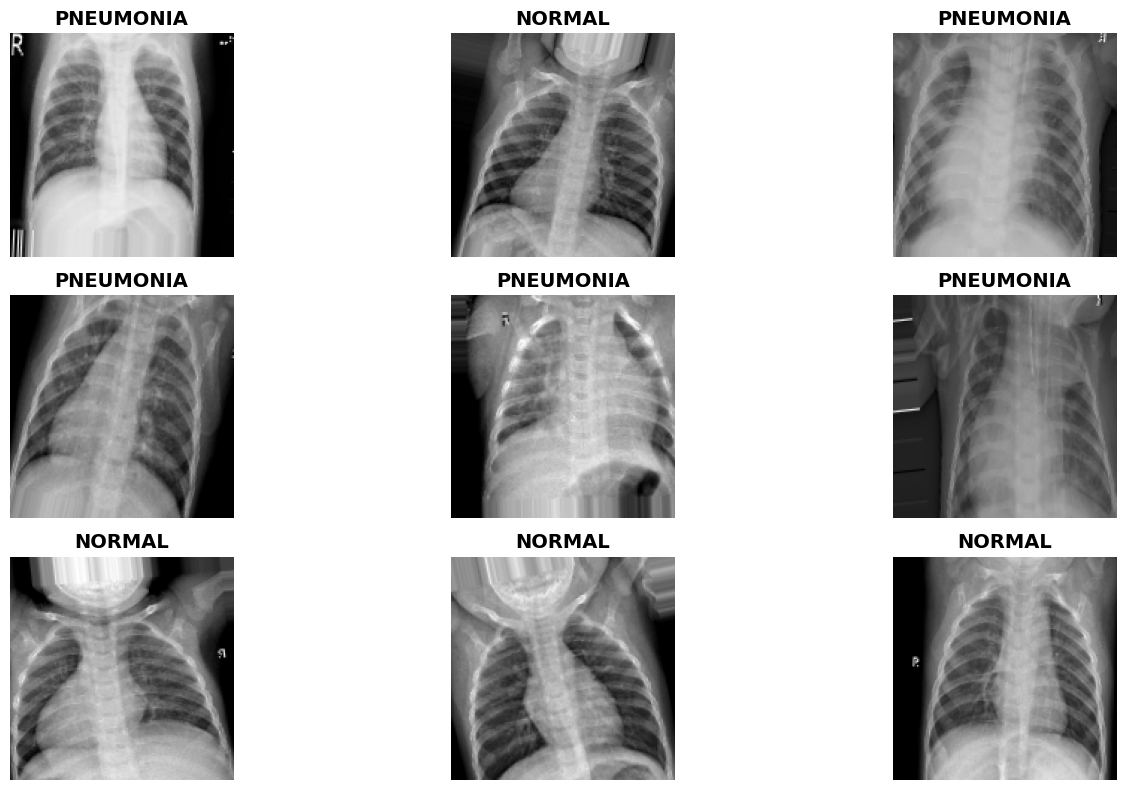

In [8]:
# Visualize sample images from training set
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 8))
sample_images, sample_labels = next(train_generator)

for i in range(min(9, len(sample_images))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    label_idx = int(sample_labels[i])
    plt.title(f'{class_names[label_idx]}', fontsize=14, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Build CNN Model

Creating a Convolutional Neural Network for binary classification (Normal vs Pneumonia).

In [9]:
def build_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    """
    Build a CNN model for pneumonia classification
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Dense Layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        # Output Layer (binary classification: 0=NORMAL, 1=PNEUMONIA)
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Build the model
model = build_cnn_model()
print("✓ Model created successfully!")

c:\Users\bsams\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✓ Model created successfully!


In [10]:
# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,940,449 (41.73 MB)

 Trainable params: 10,938,785 (41.73 MB)

 Non-trainable params: 1,664 (6.50 KB)

# Compile the Model

In [11]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # For binary classification
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall')]
)

print("✓ Model compiled successfully!")

✓ Model compiled successfully!


# Setup Callbacks

Callbacks help improve training by:
- **EarlyStopping**: Stop if validation loss doesn't improve
- **ReduceLROnPlateau**: Lower learning rate when stuck
- **ModelCheckpoint**: Save the best model

In [12]:
# Setup callbacks for better training
callbacks = [
    # Stop training if validation loss doesn't improve
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when stuck
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        'best_pneumonia_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("✓ Callbacks configured!")

✓ Callbacks configured!


# Train the Model

This will take some time (10-20 minutes depending on your computer). The model will train for up to 25 epochs, but may stop early if it stops improving.

In [13]:
# Train the model
EPOCHS = 25

print(f"Starting training for up to {EPOCHS} epochs...")
print(f"Training on {train_generator.samples} images")
print(f"Validating on {val_generator.samples} images\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*50)
print("✓ Training completed!")
print("="*50)

Starting training for up to 25 epochs...
Training on 5216 images
Validating on 16 images

Epoch 1/25
Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7813 - loss: 0.5339 - precision: 0.9255 - recall: 0.7635
Epoch 1: val_accuracy improved from None to 0.50000, saving model to best_pneumonia_model.h5

Epoch 1: val_accuracy improved from None to 0.50000, saving model to best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.8430 - loss: 0.4117 - precision: 0.9406 - recall: 0.8418 - val_accuracy: 0.5000 - val_loss: 2.8200 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/25
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9115 - loss: 0.2329 - precision: 0.9501 - recall: 0.9318
Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9120 - loss: 0.2329 - precision: 0.9457 - recall: 0.9352 - val_accuracy: 0.5000 - val_loss: 2.8274 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/25

Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9120 - loss: 0.2329 - precision: 0.9457 - recall: 0.9352 - val_accuracy: 0.5000 - val_loss: 2.8274 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9207 - loss: 0.2

163/163 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9268 - loss: 0.2024 - precision: 0.9526 - recall: 0.9486 - val_accuracy: 0.8125 - val_loss: 0.5589 - val_precision: 0.7778 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 4/25
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9375 - loss: 0.1808 - precision: 0.9590 - recall: 0.9574
Epoch 4: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.9350 - loss: 0.1865 - precision: 0.9533 - recall: 0.9595 - val_accuracy: 0.5000 - val_loss: 9.4549 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/25

Epoch 4: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.9350 - loss: 0.1865 - precision: 0.9533 - recall: 0.9595 - val_accuracy: 0.5000 - val_loss: 9.4549 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9327 - loss: 0.1

In [14]:
# Save final model
model.save('pneumonia_cnn_final_model.h5')
print("✓ Model saved as 'pneumonia_cnn_final_model.h5'")

# Save model architecture as JSON
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)
print("✓ Model architecture saved as 'model_architecture.json'")

print("\n" + "="*60)
print("ALL DONE! 🎉")
print("="*60)
print("\nYour model is trained and ready for your report!")
print("\nKey files created:")
print("  • best_pneumonia_model.h5 (best model during training)")
print("  • pneumonia_cnn_final_model.h5 (final model)")
print("  • model_architecture.json (model structure)")
print("="*60)

✓ Model saved as 'pneumonia_cnn_final_model.h5'
✓ Model architecture saved as 'model_architecture.json'

ALL DONE! 🎉

Your model is trained and ready for your report!

Key files created:
  • best_pneumonia_model.h5 (best model during training)
  • pneumonia_cnn_final_model.h5 (final model)
  • model_architecture.json (model structure)


# Save the Model

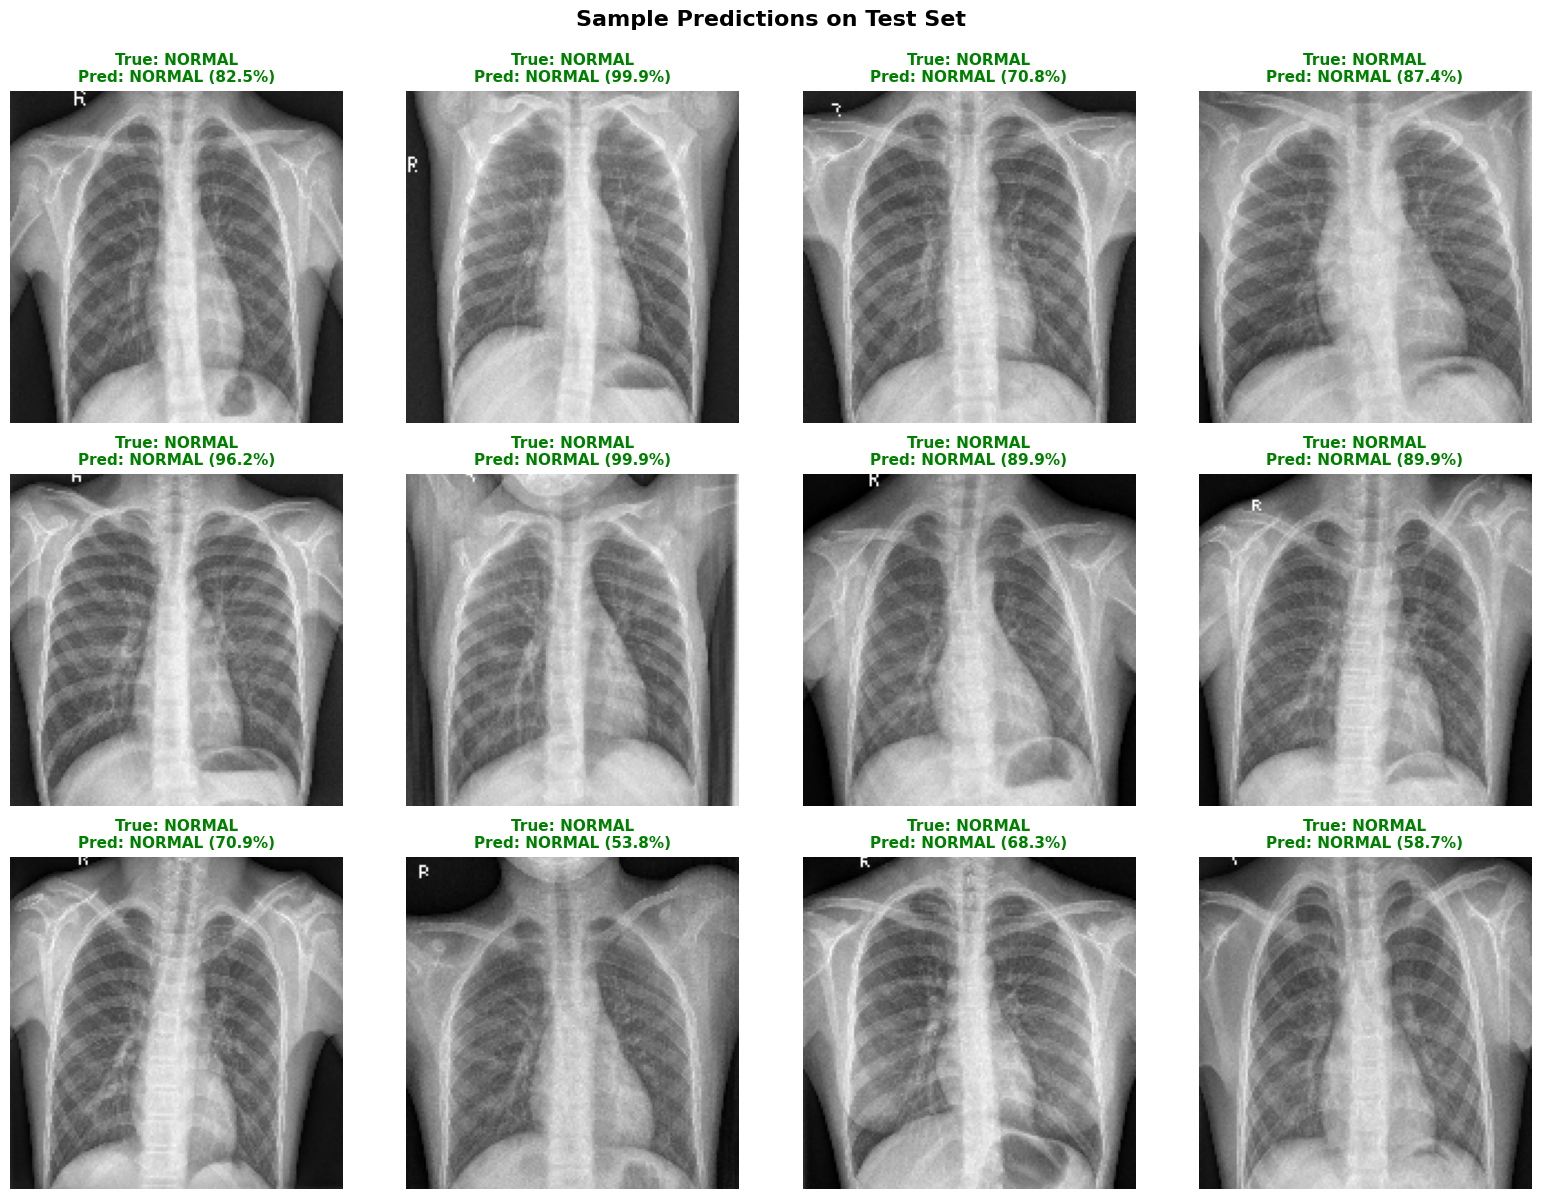

In [15]:
# Visualize some predictions
test_generator.reset()
sample_batch, sample_labels = next(test_generator)
predictions = model.predict(sample_batch, verbose=0)

plt.figure(figsize=(16, 12))
for i in range(min(12, len(sample_batch))):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_batch[i], cmap='gray')
    
    true_label = class_names[int(sample_labels[i])]
    pred_prob = predictions[i][0]
    pred_label = class_names[1 if pred_prob > 0.5 else 0]
    confidence = pred_prob if pred_prob > 0.5 else (1 - pred_prob)
    
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label} ({confidence*100:.1f}%)', 
              color=color, fontsize=11, fontweight='bold')
    plt.axis('off')

plt.suptitle('Sample Predictions on Test Set', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Visualize Predictions on Test Images

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 669ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 669ms/step


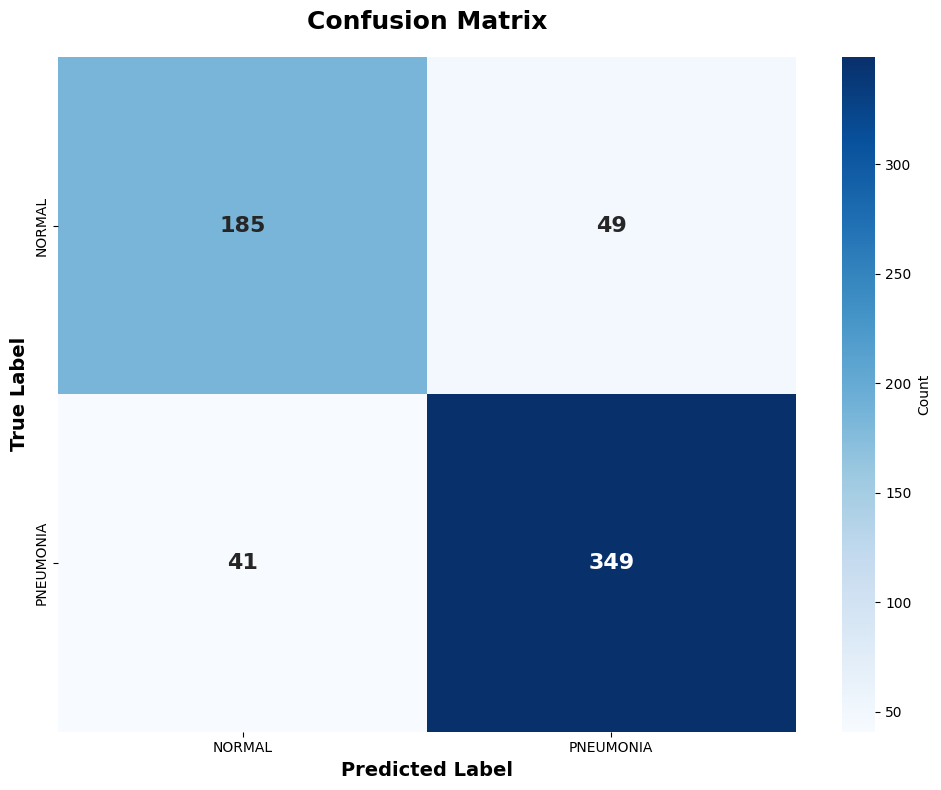


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      NORMAL     0.8186    0.7906    0.8043       234
   PNEUMONIA     0.8769    0.8949    0.8858       390

    accuracy                         0.8558       624
   macro avg     0.8477    0.8427    0.8451       624
weighted avg     0.8550    0.8558    0.8552       624



In [16]:
# Generate predictions
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Confusion Matrix', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("="*60)

# Confusion Matrix & Classification Report

In [17]:
# Evaluate model on test data
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)

# Calculate F1 Score
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print(f"\n{'='*60}")
print(f"TEST SET RESULTS:")
print(f"{'='*60}")
print(f"Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1-Score:  {f1_score:.4f}")
print(f"Test Loss:      {test_loss:.4f}")
print(f"{'='*60}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.8558 - loss: 0.3424 - precision: 0.8769 - recall: 0.8949
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.8558 - loss: 0.3424 - precision: 0.8769 - recall: 0.8949

TEST SET RESULTS:
Test Accuracy:  0.8558 (85.58%)
Test Precision: 0.8769
Test Recall:    0.8949
Test F1-Score:  0.8858
Test Loss:      0.3424

TEST SET RESULTS:
Test Accuracy:  0.8558 (85.58%)
Test Precision: 0.8769
Test Recall:    0.8949
Test F1-Score:  0.8858
Test Loss:      0.3424


# Evaluate on Test Set

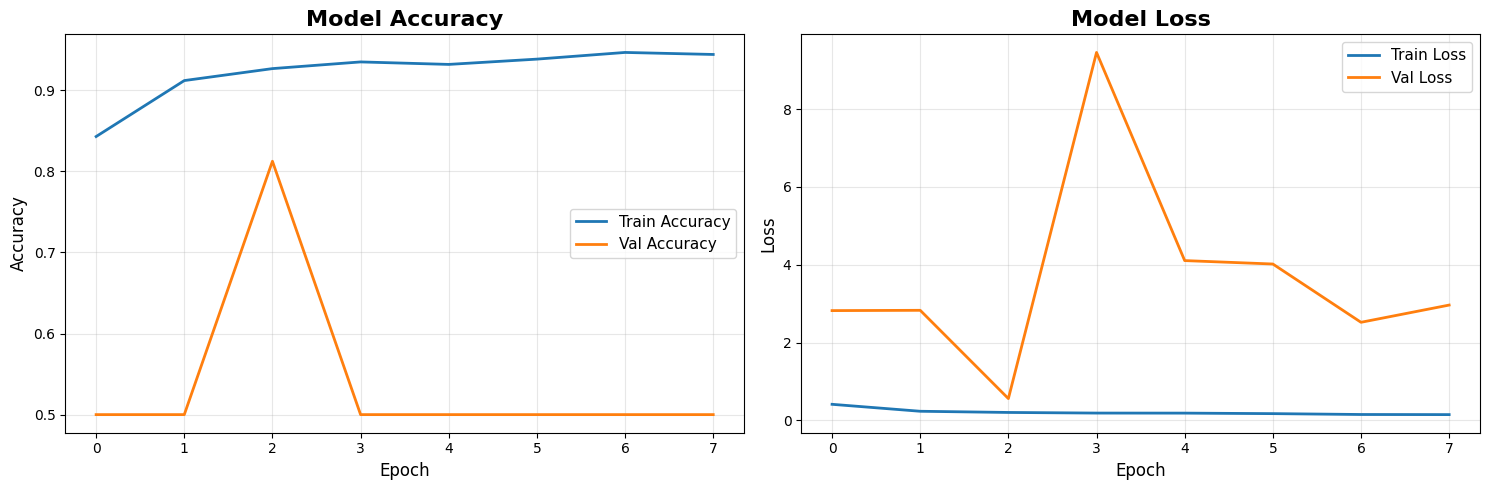

In [18]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()